In [1]:
!pip install pennylane pandas numpy scikit-learn matplotlib seaborn

In [15]:
import pennylane as qml
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, ClassifierMixin

In [16]:
df = pd.read_csv('C:/Users/SWATI SARASWATHI.S.J/Downloads/GDSC2-dataset.csv')

# Extract features and target
X = df[['MIN_CONC', 'MAX_CONC', 'LN_IC50', 'AUC', 'RMSE']].values
y = df['Z_SCORE'].values > 0  # Binary classification based on Z-score

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Set up a PennyLane device
n_qubits = X_train.shape[1]  # One qubit per feature
dev = qml.device("default.qubit", wires=n_qubits)

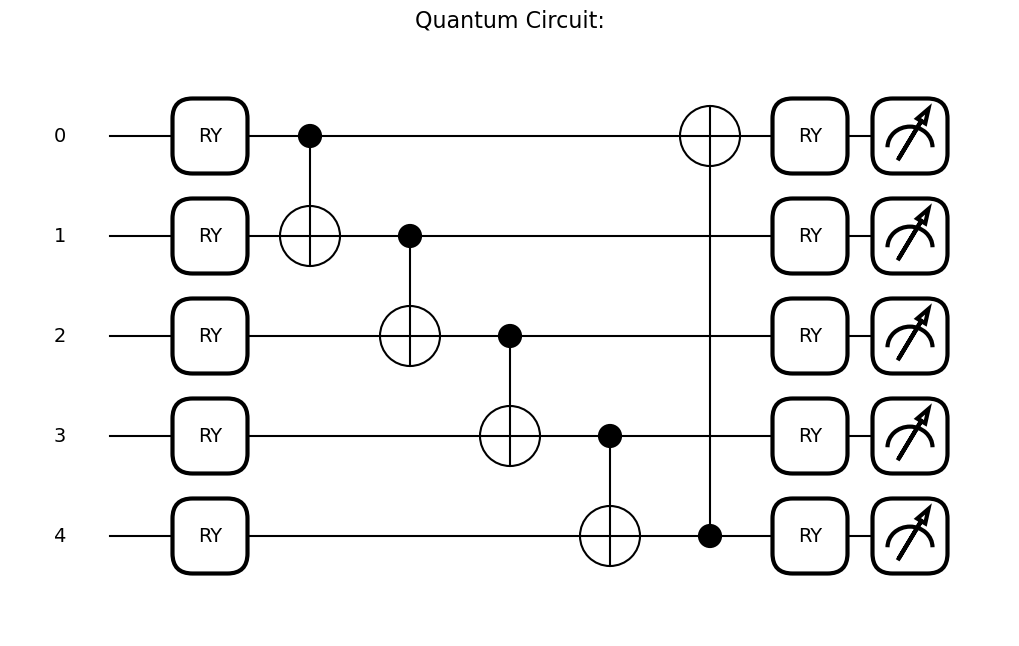

<Figure size 1200x800 with 0 Axes>

In [17]:
# Define a quantum circuit for data encoding
@qml.qnode(dev)
def quantum_circuit(x):
    # Encode features
    for i in range(n_qubits):
        qml.RY(x[i], wires=i)
    
    # Create entanglement
    for i in range(n_qubits-1):
        qml.CNOT(wires=[i, i+1])
    qml.CNOT(wires=[n_qubits-1, 0])  # Close the loop
    
    # Second encoding layer
    for i in range(n_qubits):
        qml.RY(x[i], wires=i)
        
    # Return the quantum state
    return qml.state()

np.random.seed(42)  # For reproducibility
sample_features = np.random.uniform(0, np.pi, size=n_qubits)

# Create the matplotlib visualization
fig, ax = qml.draw_mpl(quantum_circuit)(sample_features)
plt.figure(figsize=(12, 8))
ax.set_title("Quantum Circuit:", fontsize=16)
plt.tight_layout()
plt.show()

In [18]:
# Define quantum kernel function
def quantum_kernel(x1, x2):
    state1 = quantum_circuit(x1)
    state2 = quantum_circuit(x2)
    inner_product = np.vdot(state1, state2)
    # Extract scalar value if inner_product is an array
    if hasattr(inner_product, 'shape') and inner_product.shape:
        inner_product = inner_product.item()  # Convert to scalar
    return np.float32(np.abs(inner_product)**2)

In [12]:
def sample_dataset(X, y, sample_size=1000):
    """Sample a subset of the data to make kernel computation tractable"""
    if len(X) <= sample_size:
        return X, y
    
    indices = np.random.choice(len(X), sample_size, replace=False)
    return X[indices], y[indices]

# Sample your data to make computation tractable
print(f"Original dataset size: {len(X_train)} training samples")
X_train_sampled, y_train_sampled = sample_dataset(X_train, y_train, sample_size=1000)
X_test_sampled, y_test_sampled = sample_dataset(X_test, y_test, sample_size=200)
print(f"Sampled dataset size: {len(X_train_sampled)} training samples, {len(X_test_sampled)} test samples")

# Compute the kernel matrix for training data
print("Computing quantum kernel matrix for training data...")
n_train_samples = len(X_train_sampled)
K_train = np.zeros((n_train_samples, n_train_samples))

for i in range(n_train_samples):
    if i % 50 == 0:
        print(f"  Computing row {i}/{n_train_samples}...")
    for j in range(i+1):  # Compute lower triangle only (symmetric matrix)
        K_train[i, j] = quantum_kernel(X_train_sampled[i], X_train_sampled[j])
        if i != j:
            K_train[j, i] = K_train[i, j]  # Copy to upper triangle

# Train SVM with precomputed kernel
print("Training quantum SVM...")
qsvm = SVC(kernel='precomputed')
qsvm.fit(K_train, y_train_sampled)

# Prepare kernel matrix for test data
print("Computing kernel matrix for test data...")
n_test_samples = len(X_test_sampled)
K_test = np.zeros((n_test_samples, n_train_samples))

for i in range(n_test_samples):
    if i % 20 == 0:
        print(f"  Computing row {i}/{n_test_samples}...")
    for j in range(n_train_samples):
        K_test[i, j] = quantum_kernel(X_test_sampled[i], X_train_sampled[j])

# Make predictions
print("Making predictions...")
y_pred_quantum = qsvm.predict(K_test)

# Evaluate results
q_accuracy = accuracy_score(y_test_sampled, y_pred_quantum)
q_precision = precision_score(y_test_sampled, y_pred_quantum)
q_recall = recall_score(y_test_sampled, y_pred_quantum)
q_f1 = f1_score(y_test_sampled, y_pred_quantum)

print("\nQuantum SVM Results:")
print(f"Accuracy: {q_accuracy:.4f}")
print(f"Precision: {q_precision:.4f}")
print(f"Recall: {q_recall:.4f}")
print(f"F1 Score: {q_f1:.4f}")

Original dataset size: 181527 training samples
Sampled dataset size: 1000 training samples, 200 test samples
Computing quantum kernel matrix for training data...
  Computing row 0/1000...
  Computing row 50/1000...
  Computing row 100/1000...
  Computing row 150/1000...
  Computing row 200/1000...
  Computing row 250/1000...
  Computing row 300/1000...
  Computing row 350/1000...
  Computing row 400/1000...
  Computing row 450/1000...
  Computing row 500/1000...
  Computing row 550/1000...
  Computing row 600/1000...
  Computing row 650/1000...
  Computing row 700/1000...
  Computing row 750/1000...
  Computing row 800/1000...
  Computing row 850/1000...
  Computing row 900/1000...
  Computing row 950/1000...
Training quantum SVM...
Computing kernel matrix for test data...
  Computing row 0/200...
  Computing row 20/200...
  Computing row 40/200...
  Computing row 60/200...
  Computing row 80/200...
  Computing row 100/200...
  Computing row 120/200...
  Computing row 140/200...
  Comp

In [19]:
'''# Use precomputed kernel with SVC
print("Training quantum SVM...")
qsvm = SVC(kernel='precomputed')
qsvm.fit(X_train, y_train)
y_pred_quantum = qsvm.predict(X_test)

# Evaluate quantum SVM
q_accuracy = accuracy_score(y_test, y_pred_quantum)
q_precision = precision_score(y_test, y_pred_quantum)
q_recall = recall_score(y_test, y_pred_quantum)
q_f1 = f1_score(y_test, y_pred_quantum)

print("\nQuantum SVM Results:")
print(f"Accuracy: {q_accuracy:.4f}")
print(f"Precision: {q_precision:.4f}")
print(f"Recall: {q_recall:.4f}")
print(f"F1 Score: {q_f1:.4f}")'''

# Compare with classical SVM
print("\nTraining classical SVM...")
classical_svm = SVC(kernel='rbf')
classical_svm.fit(X_train, y_train)
y_pred_classical = classical_svm.predict(X_test)

# Calculate classical performance
c_accuracy = accuracy_score(y_test, y_pred_classical)
c_precision = precision_score(y_test, y_pred_classical)
c_recall = recall_score(y_test, y_pred_classical)
c_f1 = f1_score(y_test, y_pred_classical)

print("\nClassical SVM Results:")
print(f"Accuracy: {c_accuracy:.4f}")
print(f"Precision: {c_precision:.4f}")
print(f"Recall: {c_recall:.4f}")
print(f"F1 Score: {c_f1:.4f}")



Training classical SVM...

Classical SVM Results:
Accuracy: 0.7664
Precision: 0.8038
Recall: 0.7094
F1 Score: 0.7537
